## Imports


In [1]:
import numpy as np
from icecream import ic
from gxgp import  Node
from tqdm import tqdm
import operator
import inspect
from joblib import Parallel, delayed

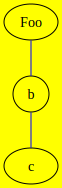

In [2]:
import pydot
import os
import graphviz
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\\bin'

graph = pydot.Dot("my_graph", graph_type="graph", bgcolor="yellow")

# Add nodes
my_node = pydot.Node("a", label="Foo")
graph.add_node(my_node)
# Or, without using an intermediate variable:
graph.add_node(pydot.Node("b", shape="circle"))

# Add edges
my_edge = pydot.Edge("a", "b", color="blue")
graph.add_edge(my_edge)
# Or, without using an intermediate variable:
graph.add_edge(pydot.Edge("b", "c", color="blue"))
graph.write_png("output.png")
graphviz.Source(graph.to_string())

In [3]:
def true_f(x: np.ndarray) -> np.ndarray:
    return x[0] + np.sin(x[1]) / 5
def true_f2(x: np.ndarray) -> np.ndarray:
    return x[0] + np.sin(x[1]) / 5 + x[0] * x[2] / 10

In [4]:
def my_f(x: np.ndarray) -> np.ndarray:
    return np.minimum(np.divide(np.maximum(np.maximum(x[1],x[2]),np.absolute(435)),np.sqrt(385)),x[0])

In [5]:
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean((y_true - y_pred) ** 2)

In [6]:
TEST_SIZE = 10_000
TRAIN_SIZE = 1000

def gen_problem():
    x_validation = np.vstack(
        [
            np.random.random_sample(size=TEST_SIZE) * 2 * np.pi - np.pi,
            np.random.random_sample(size=TEST_SIZE) * 2 - 1,
        ]
    )
    y_validation = true_f(x_validation)
    train_indexes = np.random.choice(TEST_SIZE, size=TRAIN_SIZE, replace=False)
    x_train = x_validation[:, train_indexes]
    y_train = y_validation[train_indexes]
    assert np.all(y_train == true_f(x_train)), "D'ho"
    return x_train, y_train
def gen_problem2():
    x_validation = np.vstack(
        [
            np.random.random_sample(size=TEST_SIZE) * np.exp(3)-np.exp(1),
            np.random.random_sample(size=TEST_SIZE) * 2 - 1,
            np.random.random_sample(size=TEST_SIZE) * 57 - 1,
        ]
    )
    y_validation = true_f2(x_validation)
    train_indexes = np.random.choice(TEST_SIZE, size=TRAIN_SIZE, replace=False)
    x_train = x_validation[:, train_indexes]
    y_train = y_validation[train_indexes]
    assert np.all(y_train == true_f2(x_train)), "D'ho"
    return x_train, y_train

# np.savez('problem_0.npz', x=x_train, y=y_train)
# problem = np.load('problem_0.npz')
# x = problem['x']
# y = problem['y']

problem = gen_problem2()
x = problem[0]
y = problem[1]

number_vars = x.shape[0]
# compute mse with truef as reference
m_s_e = mse(my_f(x), y)
m_s_e



np.float64(897.4605558393405)

### Getting numpy functions

In [7]:
def get_np_functions()->list[tuple[np.ufunc,str,int]]:
    # Get all attributes of numpy module
    all_attrs = dir(np)

    # Filter to include only ufunc objects
    ufuncs = [getattr(np, attr) for attr in all_attrs if isinstance(getattr(np, attr), np.ufunc)]
    ufunc_list = ufuncs
    # Filter to include only common ufuncs
    # ufunc_list = [(ufunc,ufunc.__name__,ufunc.nin) for ufunc in ufuncs if ufunc.__name__ in ['absolute','add','subtract','multiply','divide','sin','cos','sinh','cosh','asin','asinh','acos','acosh','sqrt','exp','exp2','log2','log','maximum','minimum',]]
    # ufunc_list = [ufunc for ufunc in ufuncs if ufunc.__name__ in ['absolute','absolute','arccos','arccosh','add','arccos','arccosh','arcsin','arcsinh','arctan','arctan2','arctanh','arcsin','arcsinh','arctan','arctan2','arctanh','ceil','cos','cosh','exp','exp2','log','log10','log1p','log2','logaddexp','logaddexp2','maximum','minimum','multiply','power','sin','sinh','sqrt','square','subtract','tan','tanh','divide']]
    ufunc_list = [ufunc for ufunc in ufuncs if ufunc.__name__ in
['arctan','arcsinh','arctanh','power','log','divide','log2','arccosh','log10','tan','sin','logaddexp2','exp','maximum','minimum','add','absolute','log1p','square','multiply','sqrt','exp2','cos','subtract','arcsin','tanh','ceil','arccos','logaddexp','sinh','cosh']]
    return ufunc_list


In [8]:
list(set(['absolute','absolute','arccos','arccosh','add','arccos','arccosh','arcsin','arcsinh','arctan','arctanh','arcsin','arcsinh','arctan','arctanh','ceil','cos','cosh','exp','exp2','log','log10','log1p','log2','logaddexp','logaddexp2','maximum','minimum','multiply','power','sin','sinh','sqrt','square','subtract','tan','tanh','divide']))

['subtract',
 'ceil',
 'arccos',
 'tan',
 'divide',
 'log',
 'arccosh',
 'cosh',
 'log2',
 'power',
 'arctanh',
 'sinh',
 'logaddexp2',
 'multiply',
 'logaddexp',
 'maximum',
 'sqrt',
 'cos',
 'exp2',
 'arcsinh',
 'log1p',
 'arctan',
 'minimum',
 'square',
 'exp',
 'arcsin',
 'absolute',
 'log10',
 'tanh',
 'add',
 'sin']

## Symbolic Regressor


### Utilify Functions


In [9]:
from tree4 import FastTBTree
def RHH_Init():
    pass
def fitness(tree:FastTBTree,x_train:np.ndarray,y_train:np.ndarray)->float:
    res = [tree.evalute_tree(x) for x in x_train.T]
    return np.mean((res-y_train)**2)
def fitness_proportional_selection(trees:list[FastTBTree],n_elems=2)->list[FastTBTree]:
    """
    Windowing version of fitness proportional selection
    Each tree has a probability of (fitness-min(fitnesses))/(sum(fitnesses)-min(fitnesses)) to be chosen
    """
    fitnesses = np.array([tree.fitness for tree in trees])
    # print(fitnesses)
    fitnesses = fitnesses - np.min(fitnesses)
    fitnesses = fitnesses / np.sum(fitnesses)
  
    return np.random.choice(trees, n_elems, p=fitnesses)
def tournament_selection(trees:list[FastTBTree],n_elems=2)->list[FastTBTree]:
    """
    Tournament selection
    """
    challengers = np.random.choice(trees, n_elems)
    return sorted(challengers, key=lambda x: x.fitness)[0]


def mutation(tree:FastTBTree)->FastTBTree:
    """
    Mutation of a tree
    Randomly select a mutation method and apply it
    """
    mutation_kind = np.random.randint(3)
    match mutation_kind:
        case 0:
            tree.point_mutation()
            return tree
        case 1:
            tree.expand_mutation()
            return tree
        case 2:
            tree.subtree_mutation()
            return tree
        case 3:
            # tree.hoist_mutation()
            return tree


def render_tree(tree:FastTBTree):
    return graphviz.Source(str(tree.to_graph()))

## Regression 

### Initialization

In [10]:
def eval_fitness(elem,FIX_NAN,x,y):
        elem.fitness = fitness(elem,x,y)
        if FIX_NAN and np.isnan(elem.fitness)  or np.isinf(elem.fitness):
            # elem.fitness = np.float64(NAN_PENALTY)
            elem.fitness = np.inf
        return elem

In [11]:
# N_VARS = number_vars
N_VARS = 3
MD =  6# Maximum depth
MAX_CONST = 1000 # Maximum constant value
POPULATION_SIZE = 50
OFFSPRING_SIZE = 50
GENERATIONS = 300
PM = 0.2
NAN_PENALTY = 1000
FIX_NAN = True
# np.random.seed(1)
operator_list = get_np_functions()
FastTBTree.set_params(operator_list,N_VARS,MAX_CONST)


### Random tests

In [12]:

# render_tree(treeog)

### Driver code


In [ ]:

# RHH initialization
# population = [FastTBTree.generate_random_tree_growfull(True,MD) for _ in range(POPULATION_SIZE)]
population = [FastTBTree.gen_random_tree_grow_v2(MD) for _ in range(POPULATION_SIZE)]
# population.extend([FastTBTree.generate_random_tree_growfull(False,MD+2) for _ in range(POPULATION_SIZE//3)])

best_solution = population[0]
take_over =False

for elem in population:
    elem.fitness = fitness(elem,x,y)
    if FIX_NAN and np.isnan(elem.fitness) or np.isinf(elem.fitness):
        # elem.fitness = np.float64(NAN_PENALTY)
        elem.fitness = np.inf
    # ic(elem.fitness)
offspring = []
for generation in tqdm(range(GENERATIONS)):
    offspring = []

    # parents = fitness_proportional_selection(population)
    for _ in range(OFFSPRING_SIZE,2):
        # parent selection
        # parents = [tournament_selection(population) for _ in range(2)]
        parents = [tournament_selection(population)]
        # recombination
        # o1,o2 = FastTBTree.recombination(parents[0],parents[1])
        o1, o2 = FastTBTree.crossover(parents[0],parents[1])
        offspring.append(o1)
        offspring.append(o2)

    # mutation. If take_over is True, mutate half of the population
    if take_over:
        ic("Take over!")
        for idx in range(0,OFFSPRING_SIZE,2):
            population[idx] = mutation(population[idx])
        take_over = False

    if np.random.rand() < PM:
        offspring_idx = np.random.randint(OFFSPRING_SIZE)
        population[offspring_idx]=  mutation(population[offspring_idx])

    
    population.extend(offspring)


    # parallel evaluation
    population  = Parallel(n_jobs=10)(delayed(eval_fitness)(elem,FIX_NAN,x,y) for elem in population)

    population.sort(key=operator.attrgetter('fitness'))
    population = population[:POPULATION_SIZE]
    if population[0].fitness < best_solution.fitness:
        best_solution = population[0]
    #  detection of take over
    n_best = [elem for elem in population if elem.fitness == population[0].fitness]
    n_inf = [elem for elem in population if np.isinf(elem.fitness)]

    # if len(n_best) > 0.9 * OFFSPRING_SIZE or len(n_inf) > 0.7 * OFFSPRING_SIZE:
    if len(n_best) > 0.9 * OFFSPRING_SIZE:
        take_over = True
    # print(f"Generation {generation} best fitness: {best_solution.fitness}")
best_solution


# ic([elem for elem in population if not np.isnan(elem.fitness) and not  np.isinf(elem.fitness)])

c:\Users\denni\Desktop\PythonStuff\CompInt\Labs\CI2024_lab4\tree4.py:274: RuntimeWarning: invalid value encountered in power
  return node.data(FastTBTree._evalute_tree(tree, FastTBTree.get_lchild_idx(i), x), FastTBTree._evalute_tree(tree, FastTBTree.get_rchild_idx(i), x))
c:\Users\denni\Desktop\PythonStuff\CompInt\Labs\CI2024_lab4\tree4.py:274: RuntimeWarning: overflow encountered in power
  return node.data(FastTBTree._evalute_tree(tree, FastTBTree.get_lchild_idx(i), x), FastTBTree._evalute_tree(tree, FastTBTree.get_rchild_idx(i), x))
c:\Users\denni\Desktop\PythonStuff\CompInt\Labs\CI2024_lab4\tree4.py:274: RuntimeWarning: invalid value encountered in logaddexp
  return node.data(FastTBTree._evalute_tree(tree, FastTBTree.get_lchild_idx(i), x), FastTBTree._evalute_tree(tree, FastTBTree.get_rchild_idx(i), x))
C:\Users\denni\AppData\Local\Temp\ipykernel_10796\2180791334.py:6: RuntimeWarning: overflow encountered in square
  return np.mean((res-y_train)**2)
c:\Users\denni\Desktop\PythonS

ic| [elem.fitness for elem in population]: [np.float64(959.6943174316388),
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                            inf,
                                           

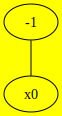

In [14]:
ic([elem.fitness for elem in population])
# # ic([elem.to_np_formula() for elem in population])
# # print(population[0].print_tree())
# best_solution.to_np_formula()
graphviz.Source(str(best_solution.to_graph()))
# best_solution.to_np_formula()
# population[0].to_np_formula()

